C:\Users\OMISTAJA\anaconda3\lib\site-packages\contextily\tile.py:581: UserWarning:

The inferred zoom level of 19 is not valid for the current tile provider (valid zooms: 0 - 18).



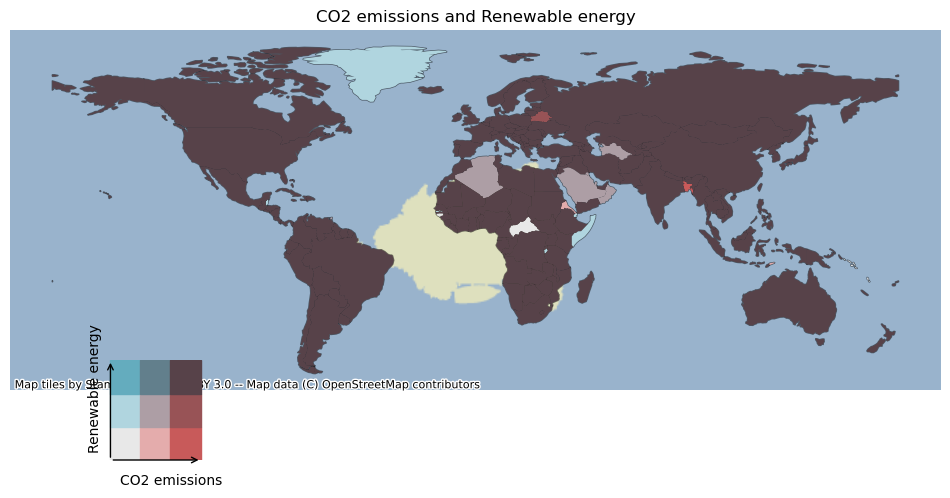

In [138]:
import pandas as pd

url = "https://raw.githubusercontent.com/pekpekkis/Data-Management-Group-Project/main/annual_co2_emissions.csv"
df_co2 = pd.read_csv(url)

url2 = "https://raw.githubusercontent.com/pekpekkis/Data-Management-Group-Project/main/annual_renewable_energy.csv"
df_green_energy = pd.read_csv(url2)

url3 = "https://raw.githubusercontent.com/pekpekkis/Data-Management-Group-Project/main/annual_population.csv"
df_population = pd.read_csv(url3, on_bad_lines='skip')
df_population = df_population.loc[:, ['Country name', 'Year', 'Population']]
df_population = df_population.rename(columns={'Country name': 'Entity'})

url4 = "https://raw.githubusercontent.com/pekpekkis/Data-Management-Group-Project/main/GDP.csv"
df_GDP = pd.read_csv(url4)

url5 = "https://raw.githubusercontent.com/pekpekkis/Data-Management-Group-Project/main/gini_coefficient.csv"
df_gini = pd.read_csv(url5)

url6 = "https://raw.githubusercontent.com/pekpekkis/Data-Management-Group-Project/main/continents.csv"
df_continents = pd.read_csv(url6)
df_continents = df_continents.drop('Year', axis='columns')

df_combined = df_co2.merge(df_green_energy, how='left', on=['Entity', 'Code', 'Year']).merge(df_population, how='left', on=['Entity', 'Year']).merge(df_GDP, how='left', on=['Entity', 'Code', 'Year']).merge(df_gini, how='left', on=['Entity', 'Code', 'Year']).merge(df_continents, how='left', on=['Entity', 'Code'])

df_combined['GDP per capita'] = df_combined['GDP (constant 2015 US$)'] / df_combined['Population']

def income_dummies(row):
    if row['GDP per capita'] < 1036:
        return 1, 0, 0, 0
    elif row['GDP per capita'] >= 1036 and row['GDP per capita'] < 4045:
        return 0, 1, 0, 0
    elif row['GDP per capita'] >= 4045 and row['GDP per capita'] < 12535:
        return 0, 0, 1, 0
    elif row['GDP per capita'] >= 12535:
        return 0, 0, 0, 1
    else:
        return 0, 0, 0, 0

df_combined[['Low income', 'Lower-middle income', 'Upper-middle income', 'High income']] = df_combined.apply(income_dummies, axis=1, result_type='expand')

def geo_dummies(row):
    if row['Continent'] == 'Africa':
        return 1, 0, 0, 0, 0, 0
    elif row['Continent'] == 'Asia':
        return 0, 1, 0, 0, 0, 0
    elif row['Continent'] == 'Europe':
        return 0, 0, 1, 0, 0, 0
    elif row['Continent'] == 'North America':
        return 0, 0, 0, 1, 0, 0
    elif row['Continent'] == 'South America':
        return 0, 0, 0, 0, 1, 0
    else:
        return 0, 0, 0, 0, 0, 1

df_combined[['Africa', 'Asia', 'Europe', 'North America', 'South America', 'Oceania']] = df_combined.apply(geo_dummies, axis=1, result_type='expand')

df_combined = df_combined.rename(columns={'Entity': 'Country', 'Annual CO₂ emissions': 'CO2 emissions', 'Renewables (% equivalent primary energy)': 'Renewable energy %', 'GDP (constant 2015 US$)': 'GDP', 'Gini coefficient': 'Gini'})
df_combined.loc[df_combined['Country'] == 'United States', 'Country'] = 'United States of America'
df_combined.loc[df_combined['Country'] == "Cote d'Ivoire", 'Country'] = "Côte d'Ivoire"
df_combined['CO2 emissions'] = df_combined['CO2 emissions'] / 1000000
df_combined = df_combined[df_combined['Code'].notna()]
df_combined = df_combined.drop('Code', axis='columns')
df_combined = df_combined.drop(df_combined[df_combined['Country'] == 'World'].index, axis=0)

df_2020 = df_combined.loc[df_combined.Year == 2020]
df_2020.dropna()

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import folium
import contextily as ctx

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.sort_values('name')
world.loc[world['name'] == 'Dem. Rep. Congo', 'name'] = 'Democratic Republic of Congo'
world.loc[world['name'] == 'Bosnia and Herz.', 'name'] = 'Bosnia and Herzegovina'
world.loc[world['name'] == 'Dominican Rep.', 'name'] = 'Dominican Republic'
world.loc[world['name'] == 'Central African Rep.', 'name'] = 'Central African Republic'
world.loc[world['name'] == 'Eq. Guinea', 'name'] = 'Equatorial Guinea'
world.loc[world['name'] == 'S. Sudan', 'name'] = 'South Sudan'
world.loc[world['name'] == 'Solomon Is.', 'name'] = 'Solomon Islands'
world.loc[world['name'] == 'Timor-Leste', 'name'] = 'Timor'


df_map_2020 = world.merge(df_2020, left_on='name', right_on='Country')

bins = [0, 0.33, 0.66, 1]

df_map_2020['Var1_Class'] = pd.cut(df_map_2020['CO2 emissions'], bins=bins, include_lowest=True)
df_map_2020['Var1_Class'] = df_map_2020['Var1_Class'].astype('str')

df_map_2020['Var2_Class'] = pd.cut(df_map_2020['Renewable energy %'], bins=bins, include_lowest=True)
df_map_2020['Var2_Class'] = df_map_2020['Var2_Class'].astype('str')

x_class_codes = np.arange(1, len(bins))
d = dict(zip(df_map_2020['Var1_Class'].value_counts().sort_index().index, x_class_codes))
df_map_2020['Var1_Class'] = df_map_2020['Var1_Class'].replace(d)

y_class_codes = ['A', 'B', 'C', 'D']
d = dict(zip(df_map_2020['Var2_Class'].value_counts().sort_index().index, y_class_codes))
df_map_2020['Var2_Class'] = df_map_2020['Var2_Class'].replace(d)

df_map_2020['Bi_Class'] = df_map_2020['Var1_Class'].astype('str') + df_map_2020['Var2_Class']

colors = ['#e8e8e8',
          '#b0d5df',
          '#64acbe',
          '#e4acac',
          '#ad9ea5',
          '#627f8c',
          '#c85a5a',
          '#985356',
          '#574249']
            
cmap = matplotlib.colors.ListedColormap(colors)

fig, ax = plt.subplots(figsize=(10, 10))

df_map_2020.to_crs('EPSG:4326').plot(ax=ax, facecolor='none', edgecolor='black', alpha=.5)

df_map_2020.to_crs('EPSG:4326').plot(ax=ax, 
                                     column='Bi_Class', 
                                     cmap=cmap, 
                                     categorical=True,
                              legend=False)


ctx.add_basemap(ax=ax, source=ctx.providers.Stamen.Terrain)

plt.tight_layout() 
plt.axis('off')
ax.set_title('CO2 emissions and Renewable energy')

img2 = fig
ax2 = fig.add_axes([0.15, 0.25, 0.1, 0.1])
alpha = 1

# Column 1
ax2.axvspan(xmin=0, xmax=0.33, ymin=0, ymax=0.33, alpha=alpha, color=colors[0])
ax2.axvspan(xmin=0, xmax=0.33, ymin=0.33, ymax=0.66, alpha=alpha, color=colors[1])
ax2.axvspan(xmin=0, xmax=0.33, ymin=0.66, ymax=1, alpha=alpha, color=colors[2])

# Column 2
ax2.axvspan(xmin=0.33, xmax=0.66, ymin=0, ymax=0.33, alpha=alpha, color=colors[3])
ax2.axvspan(xmin=0.33, xmax=0.66, ymin=0.33, ymax=0.66, alpha=alpha, color=colors[4])
ax2.axvspan(xmin=0.33, xmax=0.66, ymin=0.66, ymax=1, alpha=alpha, color=colors[5])

# Column 3
ax2.axvspan(xmin=0.66, xmax=1, ymin=0, ymax=0.33, alpha=alpha, color=colors[6])
ax2.axvspan(xmin=0.66, xmax=1, ymin=0.33, ymax=0.66, alpha=alpha, color=colors[7])
ax2.axvspan(xmin=0.66, xmax=1, ymin=0.66, ymax=1, alpha=alpha, color=colors[8])

# Step 3: annoate the legend
ax2.tick_params(axis='both', which='both', length=0) # remove ticks from the big box
ax2.axis('off'); # turn off its axis
ax2.annotate("", xy=(0, 1), xytext=(0, 0), arrowprops=dict(arrowstyle="->", lw=1)) # draw arrow for x 
ax2.annotate("", xy=(1, 0), xytext=(0, 0), arrowprops=dict(arrowstyle="->", lw=1)) # draw arrow for y 
ax2.text(s='CO2 emissions', x=0.1, y=-0.25) # annotate x axis
ax2.text(s='Renewable energy', x=-0.25, y=0.1, rotation=90); # annotate y axis

plt.show()
